# Spherical samplings for weather prediction

In [1]:
# Cartopy uses deprecated mpl features (MatplotlibDeprecationWarning).
import warnings
from matplotlib.cbook import MatplotlibDeprecationWarning
warnings.simplefilter("ignore", MatplotlibDeprecationWarning)

import numpy as np
import scipy.spatial
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import SphericalVoronoi, geometric_slerp
from scipy import sparse
import pygsp as pg
import healpy as hp
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import proj3d
import cartopy.crs as ccrs

In [2]:
def plot_mollweide(graph, signal=None, ax=None, **kwargs):
    crs = ax.projection
    ax.coastlines()
    ax.set_global()
    graph.set_coordinates('sphere', dim=2)
    graph.coords *= 180/np.pi
    graph.coords = crs.transform_points(ccrs.Geodetic(), *graph.coords.T)[:, :2]
    graph.plot(signal, ax=ax, **kwargs)

def plot_spherical_graph(graph):
    print(graph)
    fig = plt.figure(figsize=(17, 5))

    ax = fig.add_subplot(1, 3, 1, projection='3d')
    graph.set_coordinates('sphere', dim=3)
    graph.plot(indices=True, ax=ax, title='3D')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    ax = fig.add_subplot(1, 3, 2)
    graph.set_coordinates('sphere', dim=2)
    graph.plot(indices=True, ax=ax, title='Equirectangular projection')
    ax.set_xlabel('longitude [radians]')
    ax.set_ylabel('latitude [radians]')

    # ax = fig.add_subplot(1, 3, 3, projection='mollweide')
    # graph.plot(indices=True, ax=ax, title='Mollweide projection (equi-area)')

    ax = fig.add_subplot(1, 3, 3, projection=ccrs.Mollweide())
    plot_mollweide(graph, ax=ax, indices=True, title='Mollweide projection')

    fig.tight_layout()

## 1 Spherical grids

The sphere graphs are created with the [PyGSP](https://pygsp.readthedocs.io).
If the data is created from another tool, it is important to make sure the vertices/cells are ordered in the same way.
An easy way to check is to plot the data on the sampled sphere with `graph.plot(myfield)`.

### 1.1 Equiangular (Driscoll-Healy, Clenshaw-Curtis)

* Resolution parameter: number of isolatitude rings $N_{lat}$ (and pixels per ring, often $N_{lon} = 2 N_{lat}$).
* Number of pixels: $N_{pix} = N_{lat} \times N_{lon}$.
* Number of pixels around the equator: $N_{lon}$.

SphereEquiangular(n_vertices=32, n_edges=55, nlat=4, nlon=8, poles=0)


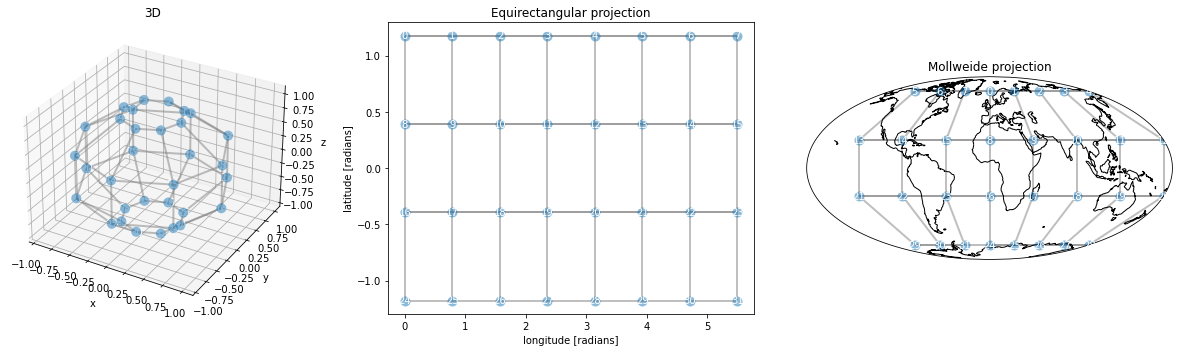

In [3]:
# Illustration.
graph = pg.graphs.SphereEquiangular(4, 8, poles=0)
#graph = pg.graphs.SphereEquiangular(4, 8, poles=2)
plot_spherical_graph(graph)

### 1.2 (Reduced) Gauss-Legendre

ECMWF: octahedral reduced Gaussian grid, named `O320` for $N=320$.

* Resolution parameter: number of isolatitude rings $N_{lat} = 2N$.
* Number of pixels: $4N(N+9)$.
* Number of pixels around the equator: $4N+16$.

References:
* <https://confluence.ecmwf.int/display/FCST/Introducing+the+octahedral+reduced+Gaussian+grid>
* <https://confluence.ecmwf.int/display/OIFS/4.2+OpenIFS%3A+Octahedral+grid>

SphereGaussLegendre(n_vertices=144, n_edges=772, nlat=6, nlon=ecmwf-octahedral, standardize=False, metric=euclidean, order=2, kind=knn, k=10, kernel=gaussian, kernel_width=4.05e-01, backend=scipy-ckdtree)


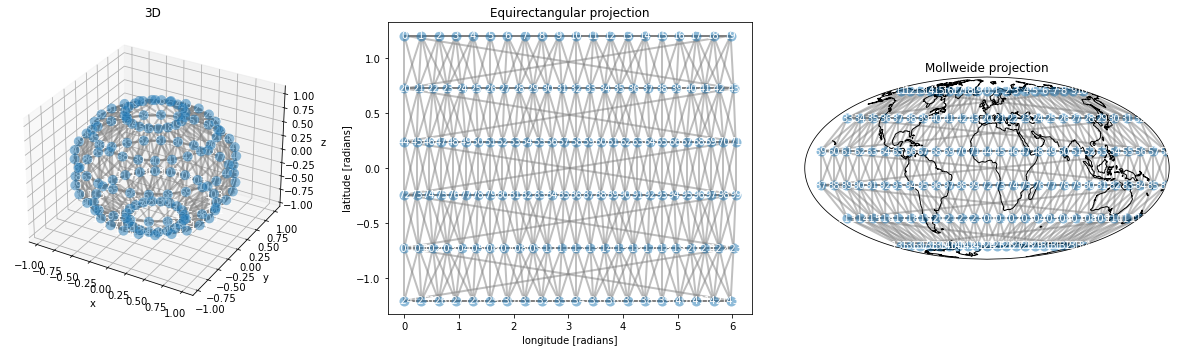

In [4]:
# Illustration.
graph = pg.graphs.SphereGaussLegendre(6, nlon='ecmwf-octahedral', k=10)
#graph = pg.graphs.SphereGaussLegendre(6, k=8)
plot_spherical_graph(graph)

### 1.3 HEALPix

* Resolution parameter: number of subdivisions $L$ ($N_{side}$).
* Number of pixels: $12 L^2$.
* Number of pixels around the equator: $4 L$.

SphereHealpix(n_vertices=48, n_edges=204, subdivisions=2, nest=False, standardize=False, metric=euclidean, order=2, kind=knn, k=8, kernel=gaussian, kernel_width=4.00e-01, backend=scipy-ckdtree)


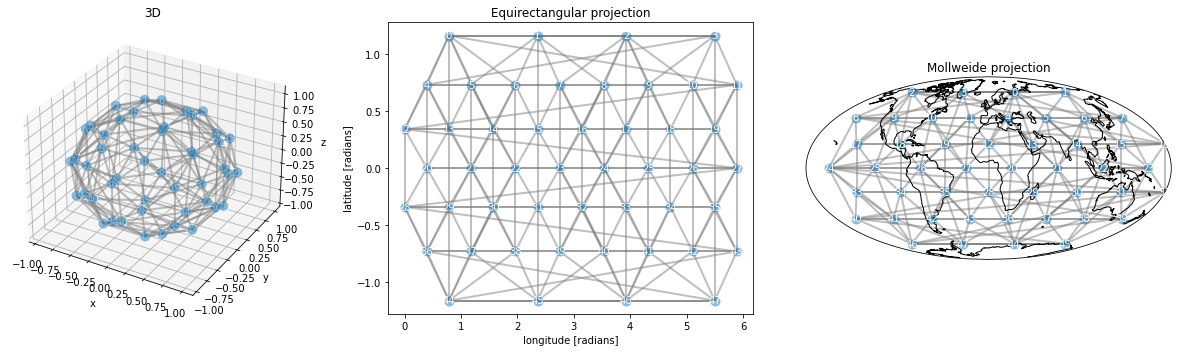

In [5]:
# Illustration.
graph = pg.graphs.SphereHealpix(2, k=8)
#graph = pg.graphs.SphereHealpix(2, k=8, nest=True)
plot_spherical_graph(graph)

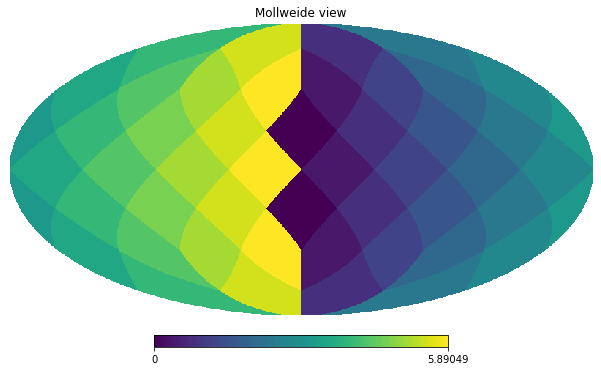

In [6]:
# Compare with healpy (geographical vs astrophysical flip).
hp.mollview(graph.signals['lon'], flip='geo')

In [7]:
# Percentage of the sphere attainable by a filter.
# The number of neighbors k is proportional to area.
kernel_size = 3
G = pg.graphs.SphereHealpix(16, k=40)
(G.L**(kernel_size-1)).nnz / G.N**2 *100

4.756503634982638

### 1.4 Icosahedral

* Resolution parameter: number of subdivisions $L$.
* Number of pixels: $10 L^2 + 2$ (vertices, hexagonal cells, `dual=False`) or $20 L^2$ (faces, triangular cells, `dual=True`).
* Number of pixels around the equator: $\approx 4L$ or $5L$.
    * The subdivided icosahedron has no prefered orientation, nor isolatitude rings.

SphereIcosahedral(n_vertices=42, n_edges=217, subdivisions=2, dual=False, standardize=False, metric=euclidean, order=2, kind=knn, k=10, kernel=gaussian, kernel_width=7.62e-01, backend=scipy-ckdtree)


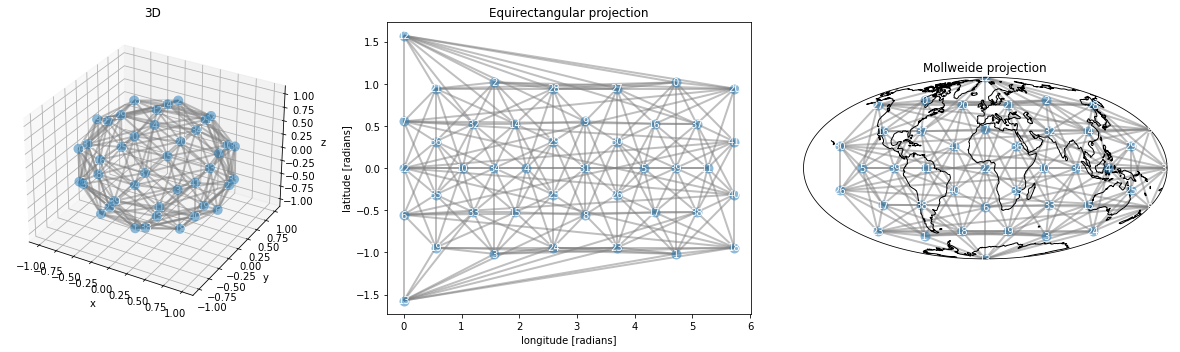

In [8]:
# Illustration.
graph = pg.graphs.SphereIcosahedral(2, dual=False)
#graph = pg.graphs.SphereIcosahedral(2, dual=True)
plot_spherical_graph(graph)

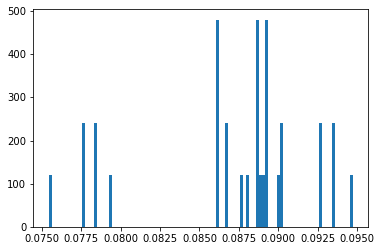

In [9]:
# Distances between pixels become less and less constant as resolution increases.
graph = pg.graphs.SphereIcosahedral(8, dual=True, k=3)
dist = squareform(pdist(graph.coords))
dist *= graph.A.toarray()
dist = dist.flatten()
dist = dist[dist!=0]
plt.hist(dist, bins=100);

### 1.5 Cubed-sphere

Used by the [US Global Forecasting Model](https://www.gfdl.noaa.gov/fv3/fv3-grids/).

* Resolution parameter: number of subdivisions $L$.
* Number of pixels: $6L^2$.
* Number of pixels around the equator: $4L$.

SphereCubed(n_vertices=54, n_edges=281, subdivisions=3, spacing=equiangular, standardize=False, metric=euclidean, order=2, kind=knn, k=10, kernel=gaussian, kernel_width=6.64e-01, backend=scipy-ckdtree)


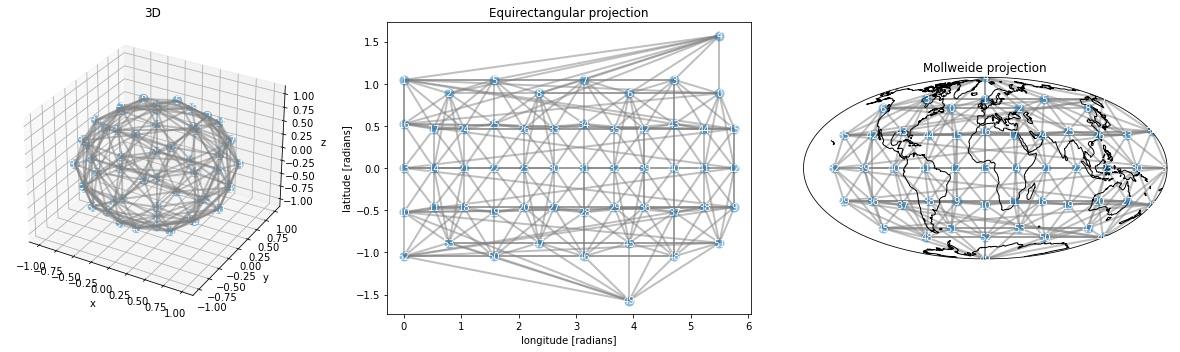

In [10]:
graph = pg.graphs.SphereCubed(3, 'equiangular')
#graph = pg.graphs.SphereCubed(3, 'equidistant')
plot_spherical_graph(graph)

## 2 Resolutions

Comparison:
1. Same average resolution (area, sqrt(area)=angle) <=> same number of pixels.
2. Same average resolution near equator (equatorial band) -> different for non-uniform samplings.

Comments:
* All pixels in HEALPix have the same area. The Icosahedral and reduced Gauss-Legendre are mostly equiarea. The Equiangular is not.

Procedure:
1. Choose the number of subdivisions for HEALPix and Icosahedral (as they are the least flexible ones).
2. Compute the resulting number of pixels (averaged between the two).
3. Choose parameters for Equiangular and Gauss-Legendre to approach that target number of pixels.
4. Add another Equiangular with 50% more pixels. It will have about the same resolution as the others at the equator.

In [11]:
def params2npix(sampling, params):
    if sampling == 'equiangular':
        nlat, nlon = params
        return nlat*nlon
    elif sampling == 'gaussian':
        nlat = params
        assert (nlat % 2) == 0
        nlat //= 2
        return 4 * nlat * (nlat+9)
    elif sampling == 'healpix':
        subdivisions = params
        return 12 * subdivisions**2
    elif sampling == 'icosahedral':
        subdivisions = params
        return 10 * subdivisions**2 + 2
    elif sampling == 'cubed':
        subdivisions = params
        return 6 * subdivisions**2

def npix2params(sampling, npix):
    if sampling == 'equiangular':
        nlat = round(np.sqrt(npix/2))
        return nlat, 2*nlat
    elif sampling == 'gaussian':
        a, b, c = 4, 36, -npix
        sol = (-b + np.sqrt(b**2 - 4*a*c)) / (2*a)
        nlat = 2*sol
        return nlat
    elif sampling == 'healpix':
        subdivisions = np.sqrt(npix / 12)
        return subdivisions
    elif sampling == 'icosahedral':
        subdivisions = np.sqrt((npix-2) / 10)
        return subdivisions
    elif sampling == 'cubed':
        subdivisions = np.sqrt(npix / 6)
        return subdivisions

assert npix2params('equiangular', params2npix('equiangular', (100, 200))) == (100, 200)
assert npix2params('gaussian', params2npix('gaussian', 80)) == 80
assert npix2params('healpix', params2npix('healpix', 5)) == 5
assert npix2params('icosahedral', params2npix('icosahedral', 5)) == 5
assert npix2params('cubed', params2npix('cubed', 8)) == 8

In [12]:
def npix2res(npix, height=1):
    radius = 6371  # radius of the Earth
    height = 2 * height * radius
    return np.sqrt(2*np.pi*radius*height/npix)

def plot_resolutions(graphs):
    # TODO: smooth with non-square window, e.g., a Gaussian.
    avg = np.pi/180*12.3456789
    bins = np.linspace(avg/2, np.pi/2-avg/2, 100)
    hist = np.empty_like(bins)
    fig, ax = plt.subplots(figsize=(10, 8))
    
    for graph in graphs:
        lat = abs(graph.signals['lat'])
        for i, bin in enumerate(bins):
            hist[i] = np.sum((lat >= bin-avg/2) & (lat <= bin+avg/2))
        hist = npix2res(hist, np.sin(bins+avg/2) - np.sin(bins-avg/2))
        label = f'{graph.__class__.__name__} ({graph.N} pixels, {npix2res(graph.N):.0f} km, {np.sqrt(180*360/graph.N):.2f}°)'
        ax.plot(bins/np.pi*180, hist, '.', label=label)
        ax.axhline(npix2res(graph.N), linestyle='--', color='grey', zorder=3)

    ax.legend()
    ax.set_xlabel('latitude [°]')
    ax.set_ylabel('mean resolution [km]')

**Target 1**: 5° resolution on average ([WeatherBench](https://github.com/pangeo-data/WeatherBench) is 5.625°).

target: 2817 pixels
21.66794868002045
44.83307533477908
(38, 76)
(46, 92)


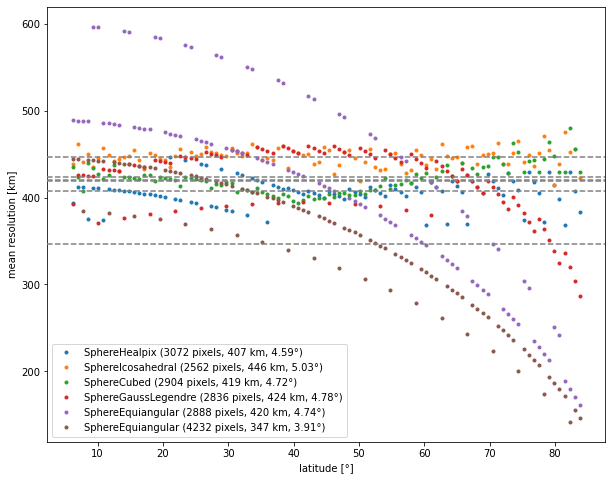

In [13]:
npix = (params2npix('healpix', 16) + params2npix('icosahedral', 16)) / 2
print(f'target: {npix:.0f} pixels')
print(npix2params('cubed', npix))
print(npix2params('gaussian', npix))
print(npix2params('equiangular', npix))
print(npix2params('equiangular', npix*1.5))

plot_resolutions([
    pg.graphs.SphereHealpix(16),
    pg.graphs.SphereIcosahedral(16),
    pg.graphs.SphereCubed(22),
    pg.graphs.SphereGaussLegendre(45, nlon='ecmwf-octahedral'),  # ECMWF uses even numbers of rings only
#    pg.graphs.SphereEquiangular(32, 64),  # WeatherBench
    pg.graphs.SphereEquiangular(38, 76),
    pg.graphs.SphereEquiangular(46, 92),
])

**Target 2**: 100 km resolution on average.

* But let's see how far we can go before the GPU memory is filled.
* For cosmology, we could train with a single GPU on HEALPix with 10 subdivisions, i.e., ~12M pixels or a resolution of ~6.4km on the Earth.
  But it was for classification, hence the NN had no decoder.
* The ECMWF's IFS HRES currently runs on a reduced (octahedral) Gaussian grid of resolution O1280, i.e., ~6M pixels or a resolution of ~8.8km on the Earth.
* ERA5 is on a reduced (linear) Gaussian grid of resolution N320 (as older IFS), which should correspond to a resolution of ~32km.

In [14]:
print(npix2res(params2npix('healpix', 10)))
print(npix2res(params2npix('gaussian', 2*1280)))

651.9614456327078
8.791259463563057


target: 45057 pixels
86.65737129638771
203.45705448395918
(150, 300)
(184, 368)


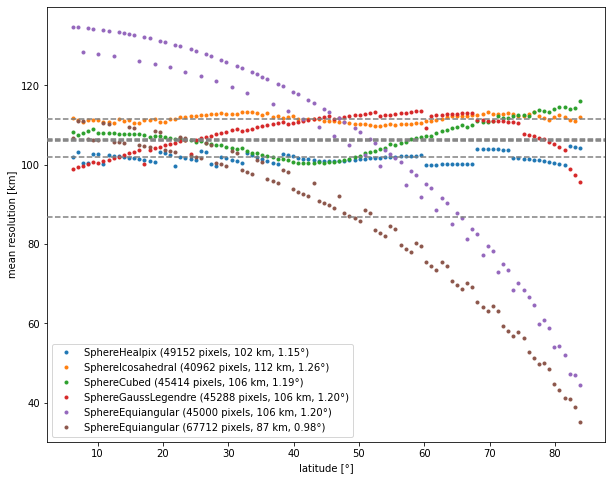

In [15]:
npix = (params2npix('healpix', 64) + params2npix('icosahedral', 64)) / 2
print(f'target: {npix:.0f} pixels')
print(npix2params('cubed', npix))
print(npix2params('gaussian', npix))
print(npix2params('equiangular', npix))
print(npix2params('equiangular', npix*1.5))

plot_resolutions([
    pg.graphs.SphereHealpix(64),
    pg.graphs.SphereIcosahedral(64),
    pg.graphs.SphereCubed(87),
    pg.graphs.SphereGaussLegendre(204, nlon='ecmwf-octahedral'),
    pg.graphs.SphereEquiangular(150, 300),
    pg.graphs.SphereEquiangular(184, 368),
])

## 3 Positions of pixels (cells) and vertices

The positions of the pixels (graph vertices) are given by a PyGSP `graph`:
1. The 3D positions of the graph vertices that support the data are stored in `graph.coords`. 
2. The longitude and latitude positions are stored as signals as `graph.signals['lon']` and `graph.signals['lat']`.
3. `graph.coords` is set to 3D coordinates with `graph.set_coordinates('sphere', dim=3)`, and 2D lat-lon coordinates with `graph.set_coordinates('sphere', dim=2)`.

In [16]:
graph = pg.graphs.SphereEquiangular(2, 4)

#graph.set_coordinates('sphere', dim=3)
print(f'{graph.coords.shape[0]} cells embedded in {graph.coords.shape[1]} dimensions')
print(graph.coords)

graph.set_coordinates('sphere', dim=2)
print(f'{graph.coords.shape[0]} cells embedded in {graph.coords.shape[1]} dimensions')
print(graph.coords)

8 cells embedded in 3 dimensions
[[ 7.07106781e-01  0.00000000e+00  7.07106781e-01]
 [ 4.32978028e-17  7.07106781e-01  7.07106781e-01]
 [-7.07106781e-01  8.65956056e-17  7.07106781e-01]
 [-1.29893408e-16 -7.07106781e-01  7.07106781e-01]
 [ 7.07106781e-01  0.00000000e+00 -7.07106781e-01]
 [ 4.32978028e-17  7.07106781e-01 -7.07106781e-01]
 [-7.07106781e-01  8.65956056e-17 -7.07106781e-01]
 [-1.29893408e-16 -7.07106781e-01 -7.07106781e-01]]
8 cells embedded in 2 dimensions
[[ 0.          0.78539816]
 [ 1.57079633  0.78539816]
 [ 3.14159265  0.78539816]
 [ 4.71238898  0.78539816]
 [ 0.         -0.78539816]
 [ 1.57079633 -0.78539816]
 [ 3.14159265 -0.78539816]
 [ 4.71238898 -0.78539816]]


A general definition of a pixel is as the set of points which are closest to a center.
Samplings can however define pixels differently, as HEALPix.

Assuming the graph vertices are at the center of cells supporting the data, those cells are given by the [Voronoi diagram](https://en.wikipedia.org/wiki/Voronoi_diagram) (the dual of a [Delaunay triangulation](https://en.wikipedia.org/wiki/Delaunay_triangulation)).
SciPy can compute a Voronoi diagram and give the positions of the Voronoi vertices at which the Voronoi cells intersect.

In [17]:
graph.set_coordinates('sphere', dim=3)
graph = pg.graphs.SphereEquiangular(2, 4)
sv = SphericalVoronoi(graph.coords, radius=1, center=[0, 0, 0])
print(f'{sv.vertices.shape[0]} vertices embedded in {sv.vertices.shape[1]} dimensions')
print(sv.vertices)

12 vertices embedded in 3 dimensions
[[ 0.70710678 -0.70710678  0.        ]
 [ 0.70710678 -0.70710678  0.        ]
 [-0.70710678 -0.70710678  0.        ]
 [-0.70710678 -0.70710678  0.        ]
 [ 0.          0.          1.        ]
 [ 0.          0.          1.        ]
 [ 0.          0.         -1.        ]
 [ 0.          0.         -1.        ]
 [ 0.70710678  0.70710678  0.        ]
 [ 0.70710678  0.70710678  0.        ]
 [-0.70710678  0.70710678  0.        ]
 [-0.70710678  0.70710678  0.        ]]


In [18]:
# HEALPix pixels aren't Voronoi cells.
graph = pg.graphs.SphereHealpix(1, k=8)
npix = graph.n_vertices
nside = np.sqrt(npix/12)
vertices = hp.boundaries(nside, range(npix), nest=graph.nest)
assert vertices.shape == (npix, 3, 4)

<ipython-input-18-b3a78e57c0b2>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  vertices = hp.boundaries(nside, range(npix), nest=graph.nest)
<ipython-input-18-b3a78e57c0b2>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


While the HEALPix pixels aren't Voronoi pixels, it's Voronoi pixels are almost equiarea.

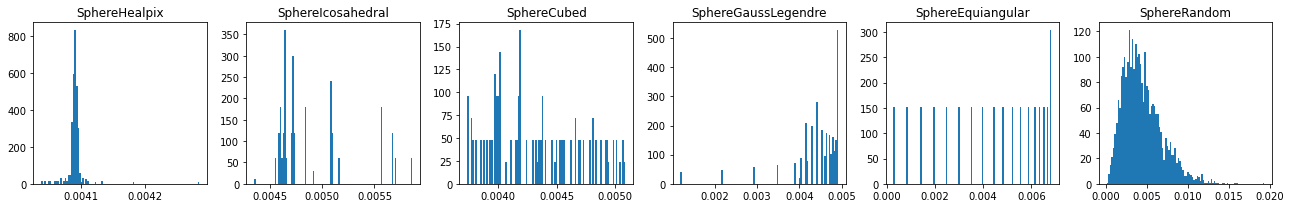

In [19]:
graphs = [
    pg.graphs.SphereHealpix(16),
    pg.graphs.SphereIcosahedral(16),
    pg.graphs.SphereCubed(22),
    pg.graphs.SphereGaussLegendre(45, nlon='ecmwf-octahedral'),
    pg.graphs.SphereEquiangular(38, 76),
    pg.graphs.SphereRandom(2817),
]

fig, axes = plt.subplots(1, len(graphs), figsize=(3*len(graphs), 3))
for graph, ax in zip(graphs, axes):
    sv = SphericalVoronoi(graph.coords, radius=1, center=[0, 0, 0])
    areas = sv.calculate_areas()
    np.testing.assert_allclose(areas.sum(), 4*np.pi)
    ax.hist(areas, bins=100)
    ax.set_title(graph.__class__.__name__)
fig.tight_layout()

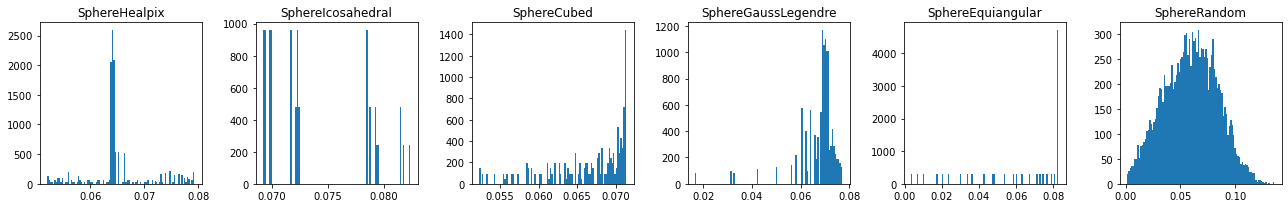

In [20]:
graphs = [
    pg.graphs.SphereHealpix(16),
    pg.graphs.SphereIcosahedral(16),
    pg.graphs.SphereCubed(22),
    pg.graphs.SphereGaussLegendre(45, nlon='ecmwf-octahedral'),
    pg.graphs.SphereEquiangular(38, 76),
    pg.graphs.SphereRandom(2817),
]
fig, axes = plt.subplots(1, len(graphs), figsize=(3*len(graphs), 3))
for graph, ax in zip(graphs, axes):
    G = pg.graphs.NNGraph(graph.coords, k=4, kernel=lambda d: d, kernel_width=1)
    ax.hist(G.W.data, bins=100)
    ax.set_title(graph.__class__.__name__)
fig.tight_layout()

## 4 Plotting

Code from <https://scipy.github.io/devdocs/generated/scipy.spatial.SphericalVoronoi.html>.

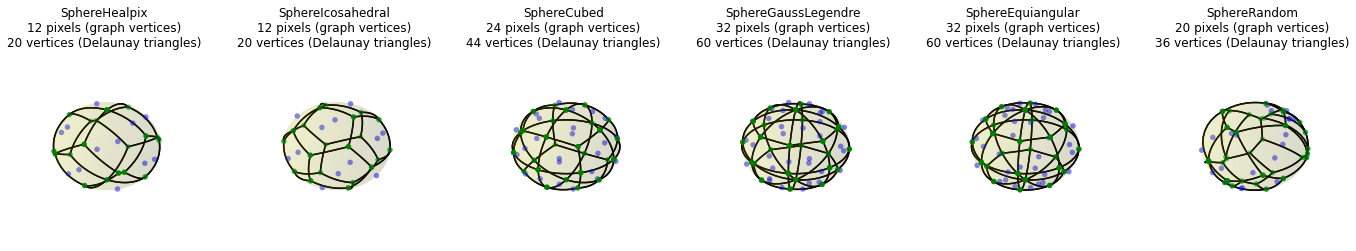

In [21]:
def plot(graph, sv, edges=True, sphere=True, triangles=False, regions=True, ax=None):
    
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

    if sphere:
        # plot the unit sphere for reference
        u = np.linspace(0, 2*np.pi, 100)
        v = np.linspace(0, np.pi, 100)
        x = np.outer(np.cos(u), np.sin(v))
        y = np.outer(np.sin(u), np.sin(v))
        z = np.outer(np.ones_like(u), np.cos(v))
        ax.plot_surface(x, y, z, color='y', alpha=0.1)

    # plot generator points (graph)
    graph.plot('b', 30, edges=edges, ax=ax, title='')

    # plot Voronoi vertices
    ax.scatter(*sv.vertices.T, c='g')

    # plot Delaunay triangles (as Euclidean polygons)
    # TODO: triangles' vertices are not sorted
    if triangles:
        t_vals = np.linspace(0, 1, 10)
        for region in sv._simplices:
            n = len(region)
            for i in range(n):
                start = sv.points[region][i]
                end = sv.points[region][(i + 1) % n]
                result = geometric_slerp(start, end, t_vals)
                ax.plot(result[..., 0],
                        result[..., 1],
                        result[..., 2],
                        c='k')

    # indicate Voronoi regions (as Euclidean polygons)
    if regions:
        sv.sort_vertices_of_regions()
        t_vals = np.linspace(0, 1, 10)
        for region in sv.regions:
            n = len(region)
            for i in range(n):
                start = sv.vertices[region][i]
                end = sv.vertices[region][(i + 1) % n]
                result = geometric_slerp(start, end, t_vals)
                # Returns a list when two vertices are at the same position.
                # Happens at the poles.
                result = np.asanyarray(result)
                ax.plot(result[..., 0],
                        result[..., 1],
                        result[..., 2],
                        c='k')

graphs = [
    pg.graphs.SphereHealpix(1, k=8),
    pg.graphs.SphereIcosahedral(1),
    pg.graphs.SphereCubed(2),
    pg.graphs.SphereGaussLegendre(4, 8),
    pg.graphs.SphereEquiangular(4, 8),
    pg.graphs.SphereRandom(20),
]

fig = plt.figure(figsize=(4*len(graphs), 4))
for i, graph in enumerate(graphs):
    ax = fig.add_subplot(1, len(graphs), i+1, projection='3d')
    sv = SphericalVoronoi(graph.coords, radius=1, center=[0, 0, 0])
    plot(graph, sv, edges=False, sphere=True, regions=True, ax=ax)
    ax.axis('off')
    title = graph.__class__.__name__
    title += f'\n{graph.n_vertices} pixels (graph vertices)'  # regions / points
    title += f'\n{sv.vertices.shape[0]} vertices (Delaunay triangles)'  # (region connections)'
    assert sv._simplices.shape[0] == sv.vertices.shape[0]
    ax.set_title(title)

## 5 Check spectral (hence equivariance) properties

In [22]:
def plot_spectrum(graphs, n_eigenvalues=49, normalize=False, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4))#figsize=(12, 8))

    for graph in graphs:
        graph.compute_fourier_basis(min(graph.N, n_eigenvalues))
        e = graph.e / graph.e[-1] if normalize else graph.e
        ax.plot(e, '.', label=f'{graph.__repr__(limit=2)}')
    ax.legend()#loc='upper left')

    eigenspace = 1
    vline = 1
    while vline <= min(n_eigenvalues, max(graph.N for graph in graphs)):
        ax.axvline(vline-0.5, linestyle='--', color='grey')
        eigenspace += 2
        vline += eigenspace

Comparison:
* HEALPix is best.
* Icosahedral and Cubed are not too bad.
    * Can be made better by using `kernel_width` from HEALPix.
* Equiangular is really bad. Worse than random. Seems to have the eigenstructure of a grid.
    * Can be made better with an `NNGraph`.
* They are all improved with more neighbors.

TODO:
* NNGraph: set sigma to mean(farthest neighbor) / 2
    * Same as for radius graph.
    * Mean pushes the width too far => most vertices are farther (as if uniform k ~ area ~ d²).
    * Kernel value 0.5 in the middle of the ball.
    * I remember it should have been in a paper. Shi-Malik?

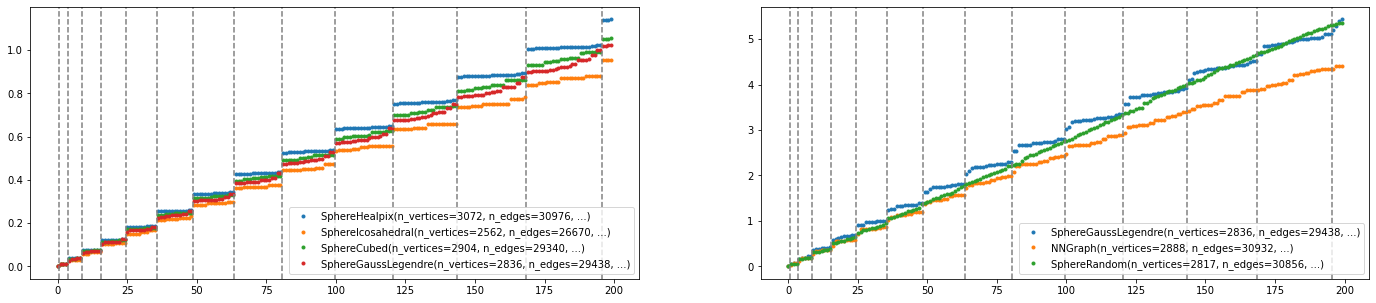

In [23]:
k = 20
lap_type = 'combinatorial'  # 'normalized' looks worse, but it hasn't been optimized for
width = pg.graphs.nngraphs.spherehealpix._OPTIMAL_KERNEL_WIDTHS[k][16]
fig, axes = plt.subplots(1, 2, figsize=(24, 5))
plot_spectrum([
    pg.graphs.SphereHealpix(16, k=k, lap_type=lap_type),
    pg.graphs.SphereIcosahedral(16, k=k, kernel_width=width, lap_type=lap_type),
    pg.graphs.SphereCubed(22, k=k, kernel_width=width, lap_type=lap_type),
    pg.graphs.SphereGaussLegendre(45, nlon='ecmwf-octahedral', k=k, kernel_width=width, lap_type=lap_type),  # better for k=8, same for k=20
#    pg.graphs.NNGraph(pg.graphs.SphereEquiangular(38, 76).coords, k=k, kernel_width=width, lap_type=lap_type),
#    pg.graphs.SphereRandom(2817, k=k, kernel_width=width, lap_type=lap_type),
], 200, ax=axes[0])
plot_spectrum([
    pg.graphs.SphereGaussLegendre(45, nlon='ecmwf-octahedral', k=k, lap_type=lap_type),  # better for k=40,60, same for k=20
#    pg.graphs.SphereEquiangular(38, 76, lap_type=lap_type),
    pg.graphs.NNGraph(pg.graphs.SphereEquiangular(38, 76).coords, k=k, lap_type=lap_type),
    pg.graphs.SphereRandom(2817, k=k, lap_type=lap_type),
], 200, ax=axes[1])
#fig.savefig('spectrum_knn_graph.png', facecolor='w', dpi=200)

HEALPix:
* eigenspaces degrade from well-separated to continuous
* separation is better with more neighbors
* the more pixels, the farther the eigenspaces are good

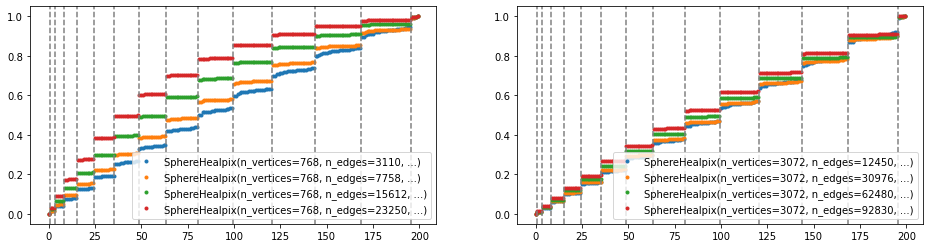

In [24]:
#nsides = [2, 4]
nsides = [8, 16]
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_spectrum([
#    pg.graphs.SphereHealpix(nsides[0], k=4, kernel_width=1),  # Faces are all quadrilaterals, but they are not equidistant. Voronoi pixels are different.
    pg.graphs.SphereHealpix(nsides[0], k=8),
    pg.graphs.SphereHealpix(nsides[0], k=20),
    pg.graphs.SphereHealpix(nsides[0], k=40),
    pg.graphs.SphereHealpix(nsides[0], k=60),
], 200, ax=axes[0], normalize=True)
plot_spectrum([
#    pg.graphs.SphereHealpix(nsides[1], k=4, kernel_width=1),
    pg.graphs.SphereHealpix(nsides[1], k=8),
    pg.graphs.SphereHealpix(nsides[1], k=20),
    pg.graphs.SphereHealpix(nsides[1], k=40),
    pg.graphs.SphereHealpix(nsides[1], k=60),
], 200, ax=axes[1], normalize=True)

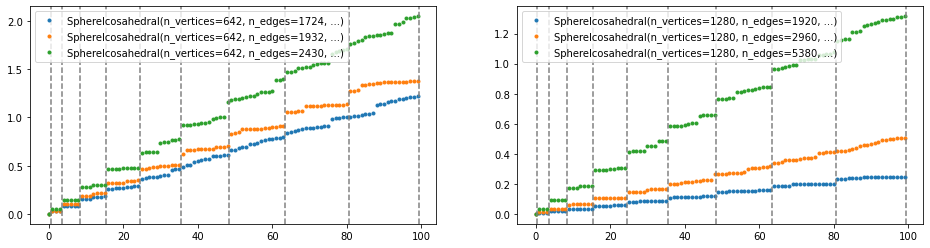

In [25]:
# k=3 is much better because there is only 1 distance, as all faces are triangles.
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_spectrum([
    pg.graphs.SphereIcosahedral(8, dual=False, k=5),
    pg.graphs.SphereIcosahedral(8, dual=False, k=6),  # Faces are mostly hexagons.
    pg.graphs.SphereIcosahedral(8, dual=False, k=7),
], 100, ax=axes[0])
plot_spectrum([
    pg.graphs.SphereIcosahedral(8, dual=True, k=3),  # Faces are all triangles.
    pg.graphs.SphereIcosahedral(8, dual=True, k=4),
    pg.graphs.SphereIcosahedral(8, dual=True, k=8),
], 100, ax=axes[1])

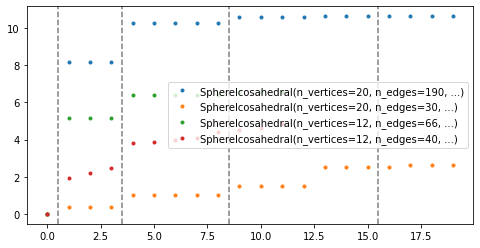

In [26]:
plot_spectrum([
    pg.graphs.SphereIcosahedral(1, dual=True, k=19),  # Fully connected.
    pg.graphs.SphereIcosahedral(1, dual=True, k=3),  # Triangular faces.
    pg.graphs.SphereIcosahedral(1, dual=False, k=11),  # Fully connected.
    pg.graphs.SphereIcosahedral(1, dual=False, k=6),  # Hexagonal faces.
])

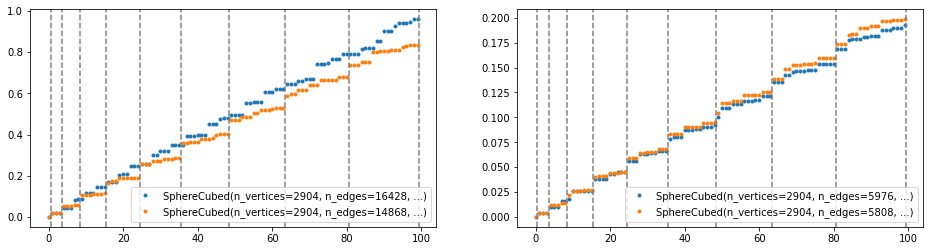

In [27]:
# SphereCubed: equiangular is better.
# Faces are quadrilaterals, but k=4 doesn't help. Aren't they equidistant?
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_spectrum([
    pg.graphs.SphereCubed(22, 'equidistant'),
    pg.graphs.SphereCubed(22, 'equiangular'),
], 100, ax=axes[0])
plot_spectrum([
    pg.graphs.SphereCubed(22, 'equidistant', k=4),
    pg.graphs.SphereCubed(22, 'equiangular', k=4),
], 100, ax=axes[1])

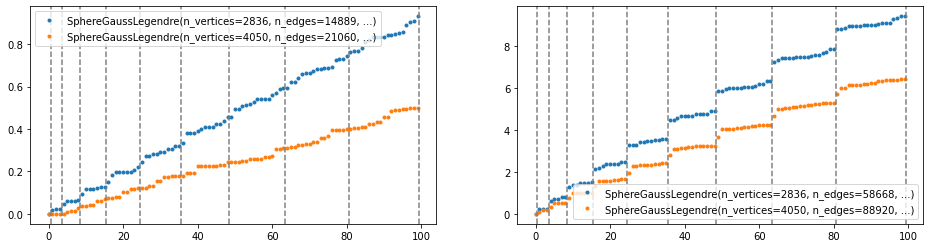

In [28]:
# SphereGaussLegendre: more neighbors and reduced (more uniform) helps.
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_spectrum([
    pg.graphs.SphereGaussLegendre(45, nlon='ecmwf-octahedral'),
    pg.graphs.SphereGaussLegendre(45, nlon=90),
], 100, ax=axes[0])
plot_spectrum([
    pg.graphs.SphereGaussLegendre(45, nlon='ecmwf-octahedral', k=40),
    pg.graphs.SphereGaussLegendre(45, nlon=90, k=40),
], 100, ax=axes[1])

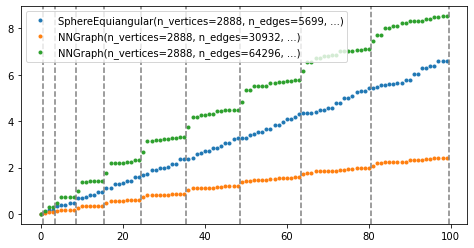

In [29]:
# SphereEquiangular: not better with more edges.
# Changing kernels doesn't help either.
# More neighbors do help.
G1 = pg.graphs.SphereEquiangular(38, 76)
plot_spectrum([
    G1,
    pg.graphs.NNGraph(G1.coords, k=20),
    pg.graphs.NNGraph(G1.coords, k=40),
#    pg.graphs.NNGraph(G1.coords, k=16, kernel=lambda d: 1/d, kernel_width=.25),
#    pg.graphs.NNGraph(G1.coords, k=4, kernel='gaussian', kernel_width=1),
#    pg.graphs.NNGraph(G1.coords, k=G1.N-1, kernel='gaussian', kernel_width=.5),
#    pg.graphs.NNGraph(G1.coords, kind='radius', radius=np.pi/20),
#    pg.graphs.NNGraph(G1.coords, kind='radius', radius=np.pi/10, kernel=lambda d: 1/d, kernel_width=1),
#    pg.graphs.NNGraph(G1.coords, k=4, kernel=lambda d: 1/d**2, kernel_width=1),
], 100)

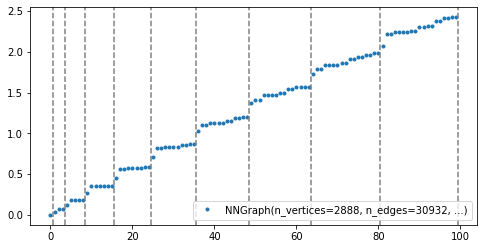

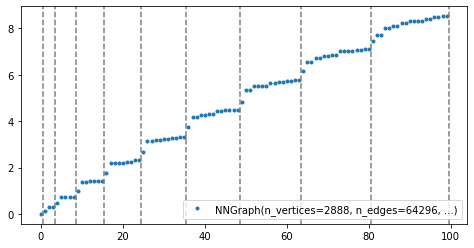

In [30]:
plot_spectrum([
    pg.graphs.NNGraph(G1.coords, k=20),
], 100)
plot_spectrum([
    pg.graphs.NNGraph(G1.coords, k=40),
], 100)

### Window function

[Tegmark, An icosahedron-based method for pixelizing the celestial sphere](https://arxiv.org/pdf/astro-ph/9610094.pdf)

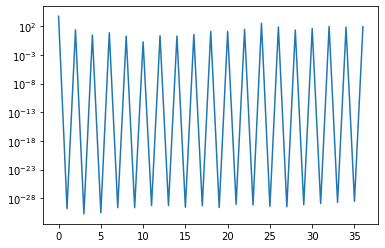

In [31]:
nside = 4
npix = 12*nside**2
w = 4*np.pi/npix * np.ones(npix)
wl = hp.anafast(w, lmax=9*nside)
plt.semilogy(wl)

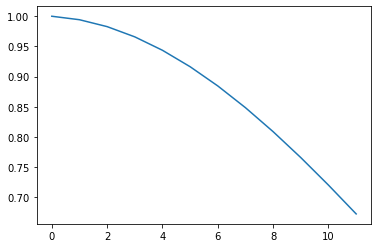

In [32]:
wl = hp.pixwin(nside, lmax=3*nside-1)
plt.plot(wl)

In [33]:
nside = 4
npix = 12*nside**2
l, m = 1, 1
graph = pg.graphs.SphereHealpix(nside)
lat, lon = hp.pix2ang(nside, range(npix))
ylm = scipy.special.sph_harm(l, m, lon, lat)

ylm @ w

(3.235259282696745e-16+1.457167719820518e-16j)

### Setting the edge weights

* Difference should be scaled by $1/d$, to get variation-per-unit-distance
* But longer edges should count less.
* Integration by summing edges connected to a vertex.
    * The more edges the more exact (quadrature).
    * Constant quadrature weights if edges go in uniform directions.

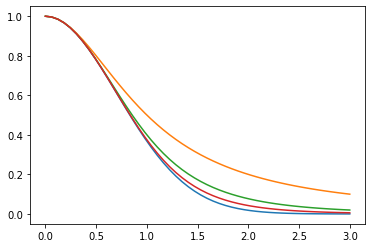

In [34]:
x = np.linspace(0, 3)
y = np.exp(-x**2)

# Taylor series.
y1 = 1 / (1 + x**2)
y2 = 1 / (1 + x**2 + x**4/2)
y3 = 1 / (1 + x**2 + x**4/2 + x**6/6)

plt.plot(x, y)
plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)

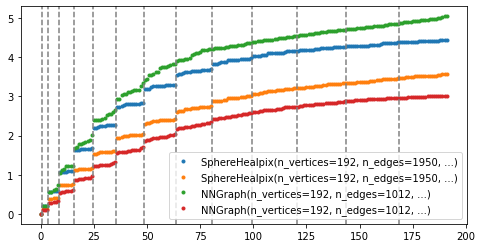

In [35]:
graph = pg.graphs.SphereHealpix(4)
plot_spectrum([
    graph,
    
    # Not so sensible to the kernel width.
    pg.graphs.SphereHealpix(4, kernel_width=0.9*graph.kernel_width),  # still ok
#    pg.graphs.SphereHealpix(4, kernel_width=0.6*graph.kernel_width),  # very bad

    # 1/d is not the solution.
    #pg.graphs.NNGraph(graph.coords, kernel=lambda d: 1/d, kernel_width=graph.kernel_width),

    # Taylor series.
    pg.graphs.NNGraph(graph.coords, kernel=lambda d: 1/(1+d**2), kernel_width=graph.kernel_width),
    #pg.graphs.NNGraph(graph.coords, kernel=lambda d: 1/(1+d**2+d**4/2), kernel_width=graph.kernel_width),
    pg.graphs.NNGraph(graph.coords, kernel=lambda d: 1/(1+d**2+d**4/2+d**6/6), kernel_width=graph.kernel_width),
], 200)

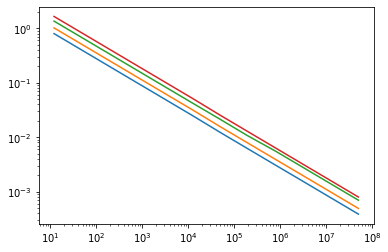

In [36]:
_OPTIMAL_KERNEL_WIDTHS = pg.graphs.nngraphs.spherehealpix._OPTIMAL_KERNEL_WIDTHS

x = np.array(list(_OPTIMAL_KERNEL_WIDTHS[8].keys()))
x = 12*x**2  # nside to npix
plt.loglog(x, list(_OPTIMAL_KERNEL_WIDTHS[8].values()))
plt.loglog(x, list(_OPTIMAL_KERNEL_WIDTHS[20].values()))
plt.loglog(x, list(_OPTIMAL_KERNEL_WIDTHS[40].values()))
plt.loglog(x, list(_OPTIMAL_KERNEL_WIDTHS[60].values()))

# width = cst / subdivisions = cst / sqrt(npix)
# width = cst * distance = cst * sqrt(area)
# weights = kernel(distances/width)

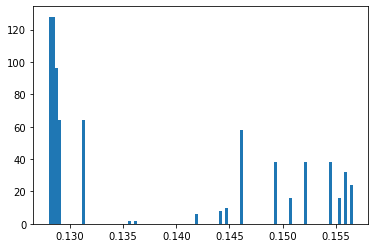

In [37]:
graph = pg.graphs.SphereHealpix(8, kernel=lambda d: d, kernel_width=1, k=4)
#min = np.min(graph.W.toarray(), axis=0)
d = np.max(graph.W.toarray(), axis=1)
#d = np.mean(graph.W.toarray(), axis=1)
#d = np.median(graph.W.toarray(), axis=1)

plt.hist(d, bins=100);
#plt.hist(graph.W.data, bins=100);

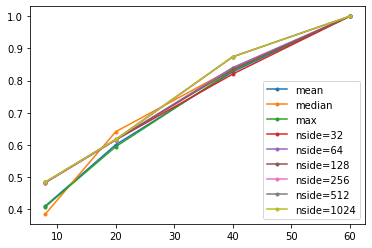

In [38]:
neighbors = [8, 20, 40, 60]
#neighbors = np.arange(10, 200, 5)
radius_mean = []
radius_median = []
radius_max = []
for k in neighbors:
    graph = pg.graphs.SphereHealpix(8, kernel=lambda d: d, kernel_width=1, k=k)
    radius_mean.append(np.mean(graph.W.data))
    radius_median.append(np.median(graph.W.data))
    radius_max.append(np.max(graph.W.data))
# All statistics have the same asymptotic behaviour.
plt.plot(neighbors, radius_mean/radius_mean[-1], '.-', label='mean')
plt.plot(neighbors, radius_median/radius_median[-1], '.-', label='median')
plt.plot(neighbors, radius_max/radius_max[-1], '.-', label='max')

for nside in [32, 64, 128, 256, 512, 1024]:
    y = np.array([_OPTIMAL_KERNEL_WIDTHS[k][nside] for k in neighbors])
    y /= y[-1]
    plt.plot(neighbors, y, '.-', label=f'nside={nside}')

#x = np.array(neighbors)
#x = np.linspace(8, 60, 100)
#y = np.linspace(y[0], 1, 100)
#plt.plot(x, y, '--', label='linear', c=(0.8,)*3)

plt.legend()

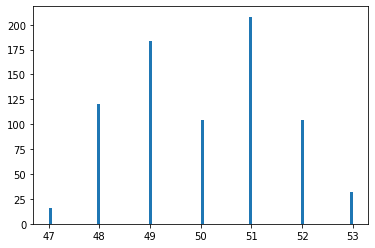

In [39]:
def nside2pixradius(nside):
    nside = 8
    npix = 12*nside**2
    pix_area = 4*np.pi / npix
    pix_radius = np.sqrt(pix_area)
    return pix_radius

nside = 8
r = 4 * nside2pixradius(nside)
graph = pg.graphs.SphereHealpix(nside, kind='radius', radius=r)
plt.hist(graph.d, bins=100);

* On a quasi-uniform sampling, a kNN graph is quasi a radius graph, with the radius given by the farthest connected pair of vertices.
* `radius` grows as `sqrt(neighbors)`, and `area=radius**2` as `neighbors`.

2021-03-18 02:35:54,452:[WARNING](pygsp.graphs.nngraphs.nngraph.__init__): 376 vertices (out of 768) are disconnected. Consider increasing the radius or setting kind=knn.
2021-03-18 02:35:55,110:[WARNING](pygsp.graphs.nngraphs.nngraph.__init__): Kernel returned similarity not in [0, 1].


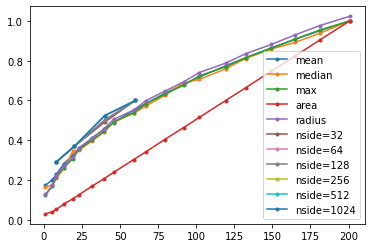

In [40]:
nside = 8
radiuses = np.linspace(1, 8, 20) * nside2pixradius(nside)

radius_mean = []
radius_median = []
radius_max = []
neighbors = []
neighbors_std = []
for r in radiuses:
    graph = pg.graphs.SphereHealpix(nside, kernel=lambda d: d, kernel_width=1, kind='radius', radius=r)
    neighbors.append(np.mean(graph.d))
    neighbors_std.append(np.std(graph.d))
    
    radius_mean.append(np.mean(graph.W.data))
    radius_median.append(np.median(graph.W.data))
    radius_max.append(np.max(graph.W.data))
#plt.plot(neighbors, radius_mean, '.-', label='mean')
#plt.plot(neighbors, radius_median, '.-', label='median')
#plt.plot(neighbors, radius_max, '.-', label='max')
plt.plot(neighbors, radius_mean/radius_mean[-1], '.-', label='mean')
plt.plot(neighbors, radius_median/radius_median[-1], '.-', label='median')
plt.plot(neighbors, radius_max/radius_max[-1], '.-', label='max')
area = np.array(radius_mean)**2
plt.plot(neighbors, area/area[-1], '.-', label='area')

#plt.plot(neighbors, radius_max/radius_max[-1], '.-', label='max')
#plt.plot(radiuses, neighbors, '.-')
plt.plot(neighbors, radiuses, '.-', label='radius')

for nside in [32, 64, 128, 256, 512, 1024]:
    neighbors = [8, 20, 40, 60]
    y = np.array([_OPTIMAL_KERNEL_WIDTHS[k][nside] for k in neighbors])
    y /= y[-1] / 0.6
    plt.plot(neighbors, y, '.-', label=f'nside={nside}')

plt.legend()

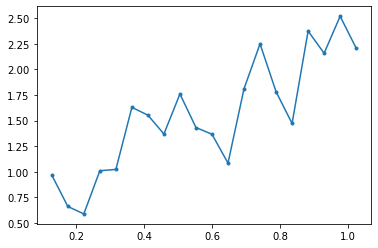

In [41]:
# The distribution of #neighbors is well concentrated.
#plt.plot(radiuses, neighbors, '.-')
plt.plot(radiuses, neighbors_std, '.-')

SphereHealpix(n_vertices=3072, n_edges=62480, subdivisions=16, nest=False, standardize=False, metric=euclidean, order=2, kind=knn, k=40, kernel=gaussian, kernel_width=8.49e-02, backend=scipy-ckdtree)
SphereGaussLegendre(n_vertices=2836, n_edges=58668, nlat=45, nlon=ecmwf-octahedral, standardize=False, metric=euclidean, order=2, kind=knn, k=40, kernel=gaussian, kernel_width=1.65e-01, backend=scipy-ckdtree)
SphereGaussLegendre(n_vertices=2836, n_edges=58668, nlat=45, nlon=ecmwf-octahedral, standardize=False, metric=euclidean, order=2, kind=knn, k=40, kernel=gaussian, kernel_width=8.49e-02, backend=scipy-ckdtree)


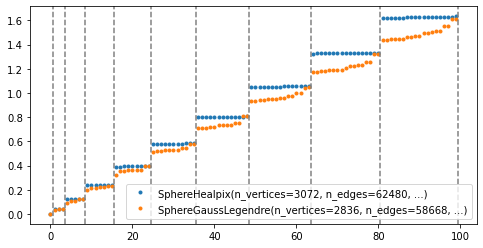

In [42]:
k = 40
nside = 8
npix = 12*nside**2
G1 = pg.graphs.SphereHealpix(16, k=k)

# Makes it better.
G2 = pg.graphs.SphereIcosahedral(8, k=k)
G3 = pg.graphs.SphereIcosahedral(8, k=k, kernel_width=G1.kernel_width)
G2 = pg.graphs.SphereIcosahedral(8, dual=True, k=k)
G3 = pg.graphs.SphereIcosahedral(8, dual=True, k=k, kernel_width=G1.kernel_width)
G2 = pg.graphs.SphereCubed(11, k=k)
G3 = pg.graphs.SphereCubed(11, k=k, kernel_width=G1.kernel_width)
G2 = pg.graphs.SphereGaussLegendre(45, 'ecmwf-octahedral', k=k)
G3 = pg.graphs.SphereGaussLegendre(45, 'ecmwf-octahedral', k=k, kernel_width=G1.kernel_width)

# Makes it worse.
#G2 = pg.graphs.SphereGaussLegendre(20, k=k)
#G3 = pg.graphs.SphereGaussLegendre(20, k=k, kernel_width=G1.kernel_width)
#G2 = pg.graphs.NNGraph(pg.graphs.SphereEquiangular(20).coords, k=k)
#G3 = pg.graphs.NNGraph(pg.graphs.SphereEquiangular(20).coords, k=k, kernel_width=G1.kernel_width)

#G4 = pg.graphs.SphereIcosahedral(8, k=6)
print(G1)
print(G2)
print(G3)
#print(G4)

plot_spectrum([
    G1,
#    G2,
    G3,
#    G4,
], 100)

### Vertex weights as areas

Can be better or worse.

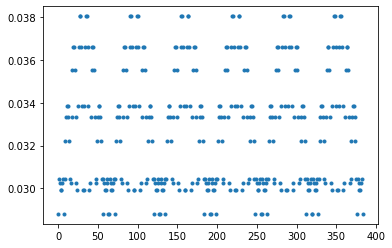

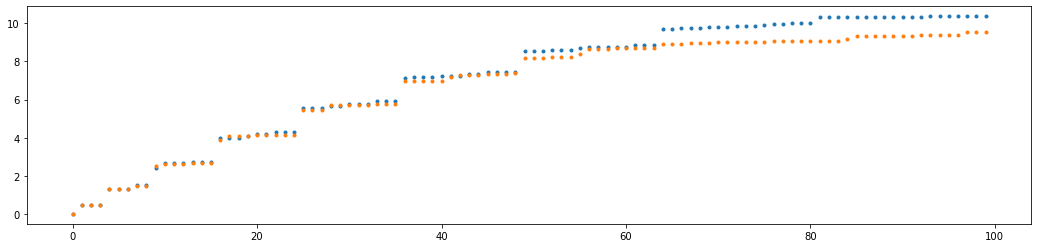

In [43]:
# Makes it a bit better.
graph = pg.graphs.SphereEquiangular(10)
# Makes it worse.
graph = pg.graphs.NNGraph(pg.graphs.SphereEquiangular(10).coords, k=10)
graph = pg.graphs.SphereGaussLegendre(20, k=20)
# Not much change (quasi-equiarea).
graph = pg.graphs.SphereIcosahedral(8)
graph = pg.graphs.SphereHealpix(8)
graph = pg.graphs.SphereCubed(8, k=20)

#plot_spectrum([graph])

sv = SphericalVoronoi(graph.coords)
areas = sv.calculate_areas()
plt.plot(areas, '.')

I = np.identity(len(areas))
D = np.diag(areas)
Di = np.diag(1/areas)

eI, UI = scipy.linalg.eigh(graph.L.toarray(), I)
eD, UD = scipy.linalg.eigh(graph.L.toarray(), D)
eDi, UDi = scipy.linalg.eigh(graph.L.toarray(), Di)

n = 100
plt.figure(figsize=(18, 4))
plt.plot(eI[:n], '.')
plt.plot(eD[:n]*np.mean(areas), '.')
#plt.plot(eDi[:n]/np.mean(areas), '.')

### Density invariant graph Laplacian

From Lafon and Coifman.

$$
\widetilde{W} = D^{-1} W D^{-1} \\
\widetilde{L} = I - D^{-1} \widetilde{W}
$$

* Doesn't seem to help either.
    * The spectrum is even worse.
    * Same for the embedding of a non-uniformly sampled circle.
    * Maybe it only works for very smooth variations of density, as shown in figure 2.5 in Lafon's thesis (p. 35)
* (Faster convergence when computing eigenvectors with $D$ as mass matrix.)

In [44]:
k = 20
graph1 = pg.graphs.SphereEquiangular(38, 76)
graph2 = pg.graphs.NNGraph(graph1.coords, k=k)

def normalize(W, d):
    Dinv = np.diag(1/d)
    return Dinv @ W @ Dinv

W = normalize(graph2.W, graph2.dw)
graph3 = pg.graphs.Graph(W)

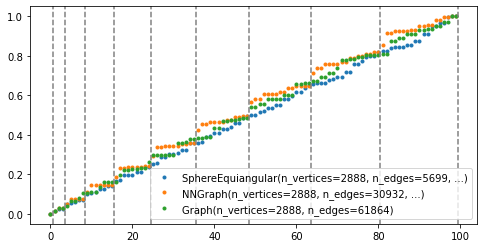

In [45]:
plot_spectrum([graph1, graph2, graph3], 100, normalize=True)

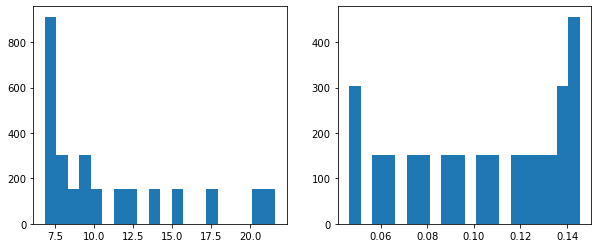

In [46]:
# The degree (density/area) concentrates.
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(graph2.dw, bins=20);
axes[1].hist(graph3.dw, bins=20);

Combinatorial vs random-walk Laplacian.
They look mostly the same.

/home/michael/.conda/envs/weather/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


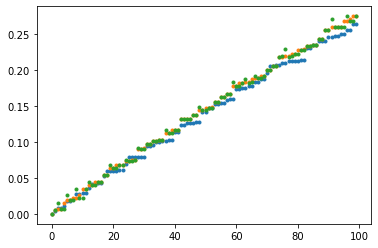

In [47]:
D = np.diag(graph3.dw)
Dinv = np.diag(1/graph3.dw)
L = D - W
#e, U = sparse.linalg.eigsh(L, k=100, which='SM')
#e, U = sparse.linalg.eigsh(L, M=np.identity(graph3.N), k=100, which='SM')
e, U = sparse.linalg.eigsh(L, M=D, k=100, which='SM')
#e, U = sparse.linalg.eigsh(L, M=Dinv, k=100, which='SM')

plt.plot(graph3.e * 10, '.')
plt.plot(e, '.')

# Should be same as random-walk L.
e, U = sparse.linalg.eigs(Dinv@L, k=100, which='SM')
#e, U = sparse.linalg.eigs(Dinv@W, k=100, which='LM')

plt.plot(e, '.')

The problem is exacerbated on a simple circle too.

/home/michael/.conda/envs/weather/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


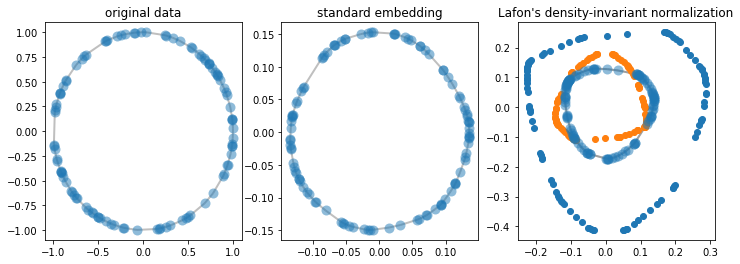

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

G1 = pg.graphs.RandomRing(100, seed=0)
G1.plot(ax=axes[0], title='original data')
G1.set_coordinates('laplacian_eigenmap3D')
G1.plot(ax=axes[1], title='standard embedding')

W = normalize(G1.W, G1.dw)
G2 = pg.graphs.Graph(W)
G2.set_coordinates('laplacian_eigenmap3D')
G2.plot(ax=axes[2], title="Lafon's density-invariant normalization")

I = np.identity(G2.N)
D = np.diag(G2.dw)
Dinv = np.diag(1/G2.dw)
L = D - W
e, U = sparse.linalg.eigsh(L, M=I, k=3, which='SM')
e, U = sparse.linalg.eigsh(L, M=D, k=3, which='SM')
axes[2].scatter(*U[:, 1:3].T)

# Same as above.
e, U = sparse.linalg.eigs(Dinv@L, k=3, which='SM')
e, U = sparse.linalg.eigs(I - Dinv@W, k=3, which='SM')
#e, U = sparse.linalg.eigs(Dinv@W, k=3, which='LM')
axes[2].scatter(*U[:, 1:3].T);

Kernel width recommended by Lafon in his thesis.
EVD doesn't converge.

In [49]:
G = pg.graphs.NNGraph(graph1.coords, k=k, kernel=lambda d: 1/d, kernel_width=1)
d = 1 / G.W.max(0).toarray().squeeze()
width = np.mean(d**2)

print(graph2)
print(width)

graph4 = pg.graphs.NNGraph(graph1.coords, k=k, kernel='gaussian', kernel_width=width)
#plot_spectrum([graph2, graph4], 100, normalize=True)

2021-03-18 02:36:28,058:[WARNING](pygsp.graphs.nngraphs.nngraph.__init__): Kernel returned similarity not in [0, 1].


NNGraph(n_vertices=2888, n_edges=30932, standardize=False, metric=euclidean, order=2, kind=knn, k=20, kernel=gaussian, kernel_width=1.13e-01, backend=scipy-ckdtree)
0.0034155069933301365


### Mesh Laplacian

1. Create a triangular mesh from a pixelized sphere (if not given).
    * Hard in general but easy on the sphere because it's convex.
2. Compute the cotan Laplacian = lumped FEM Laplacian from the mesh.
    * Use trimesh or igl.
    * Both need an $n \times 3$ matrix of vertices (entries are coordinates), and an $f \times 3$ matrix of faces (entries are vertex index).
3. Impact of the (diagonal) mass matrix.

Notes:
* Much better operator for non-uniform samplings. Not much change for HEALPix.
    * Convolutions on equiangular should work as well as on HEAPlix.
    * The eigenvalues have the correct value of $\ell (\ell + 1)$.
* Quality of convolution on discrete spheres still depends on how much they capture the geometry of the continus sphere.

Todo:
* integrate in PyGSP as `pg.graphs.Mesh(vertices, faces)`
* needs the PyGSP to accept arbitrary vertex metrics
    * the graph Laplacians (combinatorial, normalized, RW) could be abstracted out

In [50]:
import igl
#from meshplot import plot, subplot, interact

In [51]:
graph = pg.graphs.SphereHealpix(4)
graph = pg.graphs.SphereEquiangular(6, 12)
#graph = pg.graphs.SphereRandom(200)

graph.compute_fourier_basis()

def triangulate(graph):
    sv = SphericalVoronoi(graph.coords)
    assert sv.points.shape[0] == graph.n_vertices
    return sv.points, sv._simplices

v, f = triangulate(graph)
#igl.write_triangle_mesh('mesh.obj', v, f)

print(f'{v.shape[0]} vertices and {f.shape[0]} triangles')

72 vertices and 140 triangles


In [52]:
def compute_cotan_laplacian(graph, return_mass=False):
    v, f = triangulate(graph)
    L = -igl.cotmatrix(v, f)
    assert len((L - L.T).data) == 0
    M = igl.massmatrix(v, f, igl.MASSMATRIX_TYPE_VORONOI)
    # M = igl.massmatrix(v, f, igl.MASSMATRIX_TYPE_BARYCENTRIC)
    if return_mass:
        # Eliminate zeros for speed (appears for equiangular).
        L.eliminate_zeros()  
        return L, M
    else:
        Minv = sparse.diags(1 / M.diagonal())
        return Minv @ L

L, M = compute_cotan_laplacian(graph, return_mass=True)

In [53]:
# Gradient as 3D vector attached to triangle.
# Weighted average of three 1-forms (edge-valued functions).

# Boundary / difference operator (but going to face vectors).
B = igl.grad(v, f)

# Triangle area = triangle (dual vertex) weights.
Mf = igl.doublearea(v, f) / 2
Mf = sparse.diags(np.hstack(3*[Mf]))

L1 = B.T @ Mf @ B
np.testing.assert_allclose(L1.toarray(), L.toarray(), atol=1e-10)

np.unique(np.asarray((B != 0).sum(1)))

array([0, 2, 3])

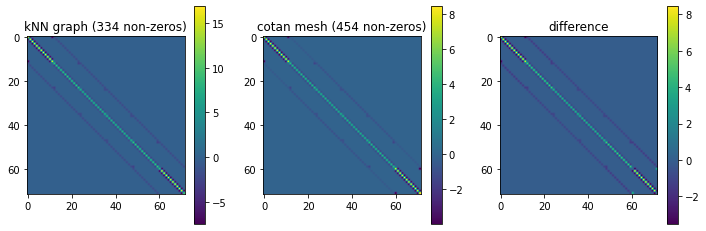

In [54]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
im = axes[0].imshow(graph.L.toarray())
fig.colorbar(im, ax=axes[0])
im = axes[1].imshow(L.toarray())
fig.colorbar(im, ax=axes[1])
im = axes[2].imshow((graph.L - L).toarray())
fig.colorbar(im, ax=axes[2])
axes[0].set_title(f'kNN graph ({graph.L.nnz} non-zeros)')
axes[1].set_title(f'cotan mesh ({L.nnz} non-zeros)');
axes[2].set_title(f'difference');

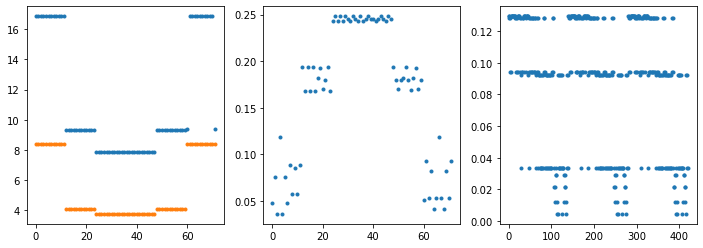

In [55]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Laplacian matrices.
axes[0].plot(graph.L.diagonal(), '.')
axes[0].plot(L.diagonal(), '.')

# Weight matrices / metrics.
# Looks like area indeed.
axes[1].plot(M.diagonal(), '.');
axes[2].plot(Mf.diagonal(), '.');

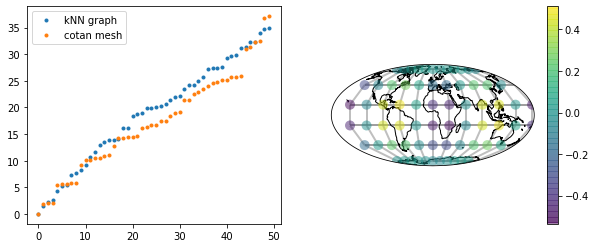

In [56]:
# Spectrum is great!
e, U = scipy.linalg.eigh(L.toarray(), M.toarray())
np.testing.assert_allclose(U.T @ M @ U, np.identity(graph.N), atol=1e-10)

# Mostly like ours without the mass matrix (vertex weights/metric).
#e, U = np.linalg.eigh(L.toarray())

# But that isn't as good either.
#e, U = scipy.linalg.eigh(graph.L.toarray(), M.toarray())

fig = plt.figure(figsize=(10, 4))

# Eigenvalues.
n = 50
ax = fig.add_subplot(1, 2, 1)
ax.plot(graph.e[:n] / graph.e[n]*e[n], '.', label='kNN graph')
ax.plot(e[:n], '.', label='cotan mesh')
ax.legend()

# Eigenvectors.
ax = fig.add_subplot(1, 2, 2, projection=ccrs.Mollweide())
plot_mollweide(graph, U[:,5], ax=ax, title='')

In [57]:
L2 = np.diag(1/M.diagonal()) @ L
e2, U2 = scipy.linalg.eig(L2)
np.testing.assert_allclose(sorted(e2), e, atol=1e-10)

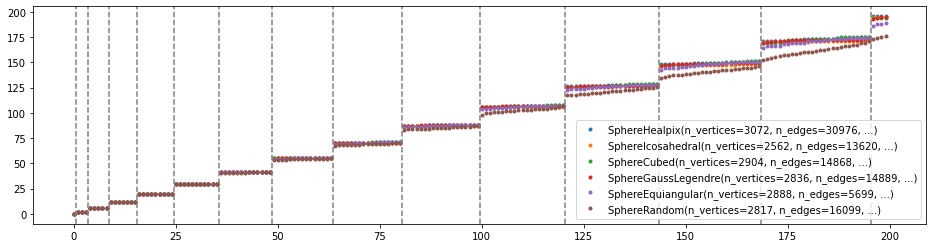

In [58]:
graphs = [
    pg.graphs.SphereHealpix(16),
    pg.graphs.SphereIcosahedral(16),
    pg.graphs.SphereCubed(22),
    pg.graphs.SphereGaussLegendre(45, nlon='ecmwf-octahedral'),
    pg.graphs.SphereEquiangular(38, 76),
    pg.graphs.SphereRandom(2817),
]

n_eigenvalues = 200

fig, ax = plt.subplots(1, 1, figsize=(16, 4))
for graph in graphs:
    L, M = compute_cotan_laplacian(graph, return_mass=True)
    
    e, U = scipy.linalg.eigh(L.toarray(), M.toarray())
    # The sparse routine (Lanzcos iteration) is much slower than the full EVD. Why?
    #e, U = sparse.linalg.eigsh(L, n_eigenvalues, M, which='SM')
    
    ax.plot(e[:n_eigenvalues], '.', label=f'{graph.__repr__(limit=2)}')
ax.legend()

eigenspace = 1
vline = 1
while vline <= min(n_eigenvalues, max(graph.N for graph in graphs)):
    ax.axvline(vline-0.5, linestyle='--', color='grey')
    eigenspace += 2
    vline += eigenspace

#fig.savefig('spectrum_cotan_mesh.png', facecolor='w', dpi=200)

### Filtering with the cotan Laplacian (a non-symmetric operator)

Without metric (or with identity metric $M=I$):
$L = U \Lambda U^\top, \ U^\top U = I, \ U^\top L U = \Lambda, \ L U = U \Lambda$
$$
\newcommand\U{\tilde{U}}
\newcommand\u{\tilde{u}}
\newcommand\L{\tilde{L}}
\newcommand\l{\tilde{\Lambda}}
$$
With a metric $M$ (for vertex-valued functions):
* Symmetric eigendecomposition: $M^{-1/2} L M^{-1/2} = U \Lambda U^\top$
* Generalized eigendecomposition: $\L = M^{-1} L = M^{-1/2} U \Lambda U^\top M^{1/2} = \U \Lambda \U^{-1}, \ L \U = M \U \Lambda$
    * can also be seen as rescaling before and after the operator
* Relation between the two eigenbases: $\U = M^{-1/2} U, \ \U^{-1} = U^\top M^{1/2} = \U^\top M$
    * Inverse $\U^{-1}$ is easily calculated.
    * $\U^{-1} \U = \U^\top M \U = (U^\top M^{-1/2}) M (M^{-1/2} U) = U^\top U = I$
    * Fourier basis $\U$ is orthonormal w.r.t. the metric $M$.
    * $\L$ is a symmetric operator w.r.t. the metric $M$.
* Function $g(\L) = g(M^{-1} L) = M^{-1/2} U g(\Lambda) U^\top M^{1/2} = \U g(\Lambda) \U^{-1} = \U g(\Lambda) \U^\top M$

Notes:
* $\tilde{L}$ is sparse (same sparsity as $L$) if $M$ is diagonal.
* Smoothest eigenvector minimizes $\lambda_i = \u_i^{-1} \L \u_i = (\u_i^\top) M (\L \u_i) = \u_i^T L \u_i$
    * inner-products (hence norms and distances) don't depend on the vertex metric
    * $\u_0$ is constant

In [59]:
graph = pg.graphs.SphereEquiangular(6, 12)
#graph = pg.graphs.SphereHealpix(16)

L, M = compute_cotan_laplacian(graph, return_mass=True)
e, U = scipy.linalg.eigh(L.toarray(), M.toarray())

Uinv = U.T @ M

np.testing.assert_allclose(Uinv, np.linalg.inv(U), atol=1e-10)
np.testing.assert_allclose(Uinv @ U, np.identity(graph.N), atol=1e-10)
np.testing.assert_allclose(U @ Uinv, np.identity(graph.N), atol=1e-10)
np.testing.assert_allclose(U.T @ M @ U, np.identity(graph.N), atol=1e-10)

Msqrt = sparse.diags(1 / np.sqrt(M.diagonal()))
Ln = Msqrt @ L @ Msqrt

en, Un = np.linalg.eigh(Ln.toarray())
en, Un = scipy.linalg.eigh(Ln.toarray(), overwrite_a=True)

np.testing.assert_allclose(en, e, atol=1e-10)

In [60]:
e_, U_ = scipy.linalg.eig(L.toarray(), M.toarray())
np.testing.assert_allclose(sorted(e_), e, atol=1e-10)
Minv = sparse.diags(1 / M.diagonal())
e_, U_ = scipy.linalg.eig((Minv @ L).toarray())
np.testing.assert_allclose(sorted(e_), e, atol=1e-10)

Filter.

In [61]:
import sys
sys.path.append('..')
from modules import layers
import torch

In [62]:
def delta(i, n):
    signal = torch.zeros((1, n, 1))
    signal[0, i] = 1
    return signal

# Identity filter.
weights = torch.zeros((1, 5, 1))
weights[0, 0] = 1
Ltorch = layers.prepare_torch_laplacian(L, torch.float32)
xin = delta(graph.N//2, graph.N)
xout = layers.cheb_conv(Ltorch, xin, weights)
np.testing.assert_allclose(xout, xin)

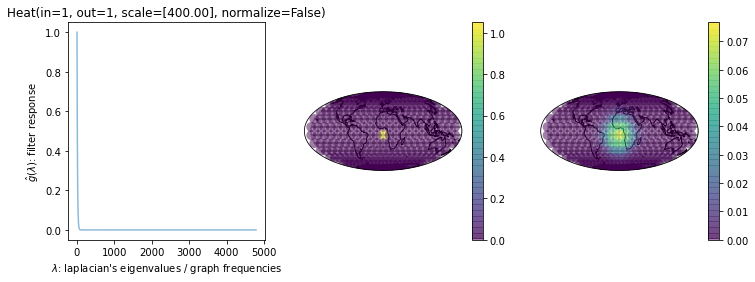

In [63]:
graph = pg.graphs.SphereEquiangular(12, 24)
#graph = pg.graphs.SphereHealpix(16)

laplacian = 'knn-graph'
laplacian = 'cotan-mesh'

if laplacian == 'knn-graph':
    Ltorch = layers.prepare_torch_laplacian(graph.L, torch.float32)
    _G = graph
    _G.estimate_lmax()
elif laplacian == 'cotan-mesh':
    L = compute_cotan_laplacian(graph)
    Ltorch = layers.prepare_torch_laplacian(L, torch.float32)
    _G = pg.graphs.Graph([[0]])
    _G._lmax = layers.estimate_lmax(L)

g = pg.filters.Heat(_G, 400)
#g = pg.filters.Wave(_G, 10)

K = 30  # polynomial order / size of filters
weights = pg.filters.approximations.compute_cheby_coeff(g, K)
weights[0] /= 2
weights = weights.reshape((1, -1, 1))
weights = torch.from_numpy(weights.astype(np.float32))

xin = delta(graph.N//2, graph.N)
xout = layers.cheb_conv(Ltorch, xin, weights)

# Compare with pygsp (identity metric only).
if laplacian == 'knn-graph':
    xout_pygsp = g.filter(xin.squeeze(), order=K)
    np.testing.assert_allclose(xout.squeeze(), xout_pygsp, atol=1e-5)

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 3, 1)
g.plot(ax=ax)
ax = fig.add_subplot(1, 3, 2, projection=ccrs.Mollweide())
plot_mollweide(graph, xin, ax=ax, title='')
ax = fig.add_subplot(1, 3, 3, projection=ccrs.Mollweide())
plot_mollweide(graph, xout, ax=ax, title='')